In [6]:
%matplotlib inline
import random
import torch
import matplotlib.pyplot as plt

Construct a synthetic dataset based on a noisy linear model. We use the linear model parameters $w=[2,−3.4]^T$, $b=4.2$, and the noise term $\epsilon$ to generate the dataset and labels:

$$y = Wx + b + ϵ$$

In [2]:
def synthetic_data(w, b, num_examples):
  """
    Generate y = Xw + b
  """
  X = torch.normal(0, 1, (num_examples, len(w))) # row_number = num_examples, column = len(w)
  y = torch.matmul(X, w) + b
  y += torch.normal(0, 0.01, y.shape)
  return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

`features`: each row include a 2-D sample

`labels`: each row include a 1-D label

In [5]:
print(f'features: {features[0:5, 0:5]} \n labels: {labels[0:5]}')

features: tensor([[ 0.4616,  0.5504],
        [ 0.1055,  0.1923],
        [ 1.7999,  1.4415],
        [ 0.7432,  0.3824],
        [-0.9891,  1.3337]]) 
 labels: tensor([[ 3.2518],
        [ 3.7510],
        [ 2.8873],
        [ 4.3878],
        [-2.3201]])


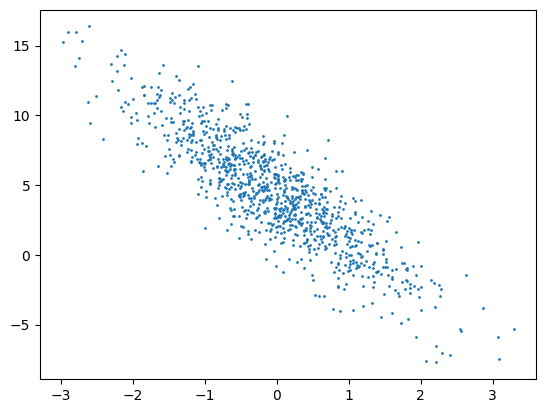

In [8]:
plt.scatter(
    features[:, 1].detach().numpy(),
    labels.detach().numpy(), 1
)

`data_iter` function: this function receive inputs with batch_size, feature matrix, label vector, and output a batch with batch size.

In [9]:
def data_iter(batch_size, features, labels):
  num_examples = len(features)
  indices = list(range(num_examples))
  random.shuffle(indices)
  for i in range(0, num_examples, batch_size):
    batch_indices = torch.tensor(
        indices[i: min(i + batch_size, num_examples)]
    )
    yield features[batch_indices], labels[batch_indices]

batch_size = 10

for X, y in data_iter(batch_size=batch_size, features=features, labels=labels):
  print(X, '\n', y) # X.size = (10, 2), y.size = (10, 1)
  break

tensor([[ 0.7048,  0.4978],
        [-0.7382, -0.5828],
        [-0.6768,  0.0162],
        [ 1.1819, -0.2609],
        [ 0.4630,  1.0296],
        [ 0.8714, -0.9195],
        [ 1.7400, -0.4540],
        [-0.3974,  1.1745],
        [-2.4380,  0.6650],
        [ 0.9820,  0.1660]]) 
 tensor([[ 3.9048],
        [ 4.6967],
        [ 2.8128],
        [ 7.4492],
        [ 1.6220],
        [ 9.0793],
        [ 9.2368],
        [-0.5991],
        [-2.9434],
        [ 5.5994]])


Define initial parameters and the model

In [24]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

def linreg(X, w, b):
  """
  linear regression model
  """
  return torch.matmul(X, w) + b

In [12]:
def squared_loss(y_hat, y):
  """
  squared loss
  """
  return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [13]:
def sgd(params, lr, batch_size):
  """
  Mini-batch Stochastic Gradient Descent
  """
  with torch.no_grad():
    for param in params:
      param -= lr * param.grad / batch_size
      param.grad.zero_()

Training Process

In [25]:
lr = 0.01
num_epochs = 5
net = linreg # in there, you can change other models
loss = squared_loss # in there, you can change other models

for epoch in range(num_epochs):
  for X, y in data_iter(batch_size, features, labels):
    l = loss(net(X, w, b), y)
    l.sum().backward()
    sgd([w, b], lr, batch_size)

  with torch.no_grad():
    train_l = loss(net(features, w, b), labels)
    print(f"epoch {epoch + 1}, loss {float(train_l.mean()):f}")

epoch 1, loss 2.059179
epoch 2, loss 0.239624
epoch 3, loss 0.027958
epoch 4, loss 0.003304
epoch 5, loss 0.000434


In [27]:
print(f"w_error: {true_w - w.reshape(true_w.shape)}")
print(f"b_error: {true_b - b}")

w_error: tensor([ 0.0062, -0.0179], grad_fn=<SubBackward0>)
b_error: tensor([0.0198], grad_fn=<RsubBackward1>)


The following is a process for linear regression implemented using PyTorch built-in modules.

In [29]:
import numpy as np
import torch
from torch.utils import data

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

def load_array(data_arrays, batch_size, is_train=True):
  """
  construct a Pytorch constructor
  """
  dataset = data.TensorDataset(*data_arrays)
  return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size=batch_size)
next(iter(data_iter))

from torch import nn
# Using the pre-defined layers provided by the framework.
net = nn.Sequential(nn.Linear(2, 1))

# initial model weights and bias
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

loss = nn.MSELoss()
trainer = torch.optim.SGD(net.parameters(), lr=0.01)

num_epochs = 10
for epoch in range(num_epochs):
  for X, y in data_iter:
    l = loss(net(X), y)
    trainer.zero_grad()
    l.backward()
    trainer.step()
  l = loss(net(features), labels)
  print(f"epoch {epoch + 1}, loss {l:f}")

epoch 1, loss 0.639137
epoch 2, loss 0.012839
epoch 3, loss 0.000360
epoch 4, loss 0.000102
epoch 5, loss 0.000097
epoch 6, loss 0.000097
epoch 7, loss 0.000097
epoch 8, loss 0.000097
epoch 9, loss 0.000097
epoch 10, loss 0.000097
